In [2]:
import arviz as az 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import pymc3 as pm 
import theano 

In [3]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.3


In [4]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [5]:
data = pd.read_csv(pm.get_data('radon.csv'))
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)

# 카운티의 이름 확인 
county_names = data.county.unique()
# 카운티에 해당하는 코드가 따로 있는 듯
# 예를 들어서
# Aitkin --> 0 
# Anoka  --> 1
# Wright --> 83 
county_idx = data.county_code.values

In [6]:
# 전체 몇개의 카운티가 있냐를 확인 
n_counties = len(data.county.unique())

In [7]:
data[['county', 'log_radon', 'floor']].head()
# basement 가 있으면 floor == 0 만약에 없으면 floor == 1

county  log_radon  floor
0  AITKIN   0.832909    1.0
1  AITKIN   0.832909    0.0
2  AITKIN   1.098612    0.0
3  AITKIN   0.095310    0.0
4   ANOKA   1.163151    0.0

In [8]:
# 우리가 궁금한 것은 basement 가 있으면 radon 이 많이 검출 되나? 

### Unpooled Model

In [9]:
# unpooled model  
# --> estimate n (number of counties) different regressions - one for each county 
with pm.Model() as unpooled_model: 
    
# independent parameters for each county 
# 우리가 지금은 각각의 카운티 마다 parameter 가 다르다. 이건 unpooled_model 이니까 
    a = pm.Normal('a', 0, sigma=100, shape=n_counties)
    b = pm.Normal('b', 0, sigma=100, shape=n_counties)
    
# model error 
    eps = pm.HalfCauchy('eps', 5)

# model prediction of radon level 
# a[county_idx] translates to a [0, 0, 0, 1, 1, ...],
# we thus link multimple household measures of a county 
    radon_est = a[county_idx] + b[county_idx] * data.floor.values 
    
# data likelihood 
# radon_set : model prediction of radon level 
# observed=data.log_radon : target 
    y = pm.Normal('y', radon_est, sigma=eps, observed=data.log_radon)

In [10]:
with unpooled_model: 
    # 여기서 posterior 을 approximation 하는데 sampling 기법으로 posterior 를 구할 것이다. 2000 iterations 
    unpooled_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 35 seconds.


### Hierarchical Model

In [11]:
# 모델을 위처럼 (unpooled model) 카운티 마다 다르게 하는 대신에, 
# hierarchical model 은 카운티 마다의 파라미터들이 unpooled model 처럼 
# 완전 다르지는 않고 어느 정도는 연관성이 있다고 가정하고 들어가는 model. 

In [12]:
with pm.Model() as hierarchical_model:
    # hyperpriors (hyperparameter) : 미리 정해주는 prior distribution 
    mu_a = pm.Normal('mu_a', mu=0, sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.0)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.0)
    
    # 위와 다르게 여기서는 a 와 b 가 어떠한 distribution 을 가진다. 
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)
    
    eps = pm.HalfCauchy('eps', 5.0)
    
    # a == intercept
    # b == slope 
    radon_est = a[county_idx] + b[county_idx]*data.floor.values
    
# data likelihood 
    radon_like = pm.Normal('radon_like', 
                           mu=radon_est,
                           sigma=eps, 
                           observed=data.log_radon)

In [13]:
with hierarchical_model:
    # 우리는 sampling 을 할때 현재로써는 다른 객기를 부리지 않고 default parameters (NUTS) 들을 이용한다. 
    # 이 말은 즉슨 우리는 일반적인 MCMC 를 이용할거다.
    # metropolis hastings algorithm 을 쓸때에는 새로운 state 를 얼마의 확률로 accept 할 것인지 명시해 주어야 함. 
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


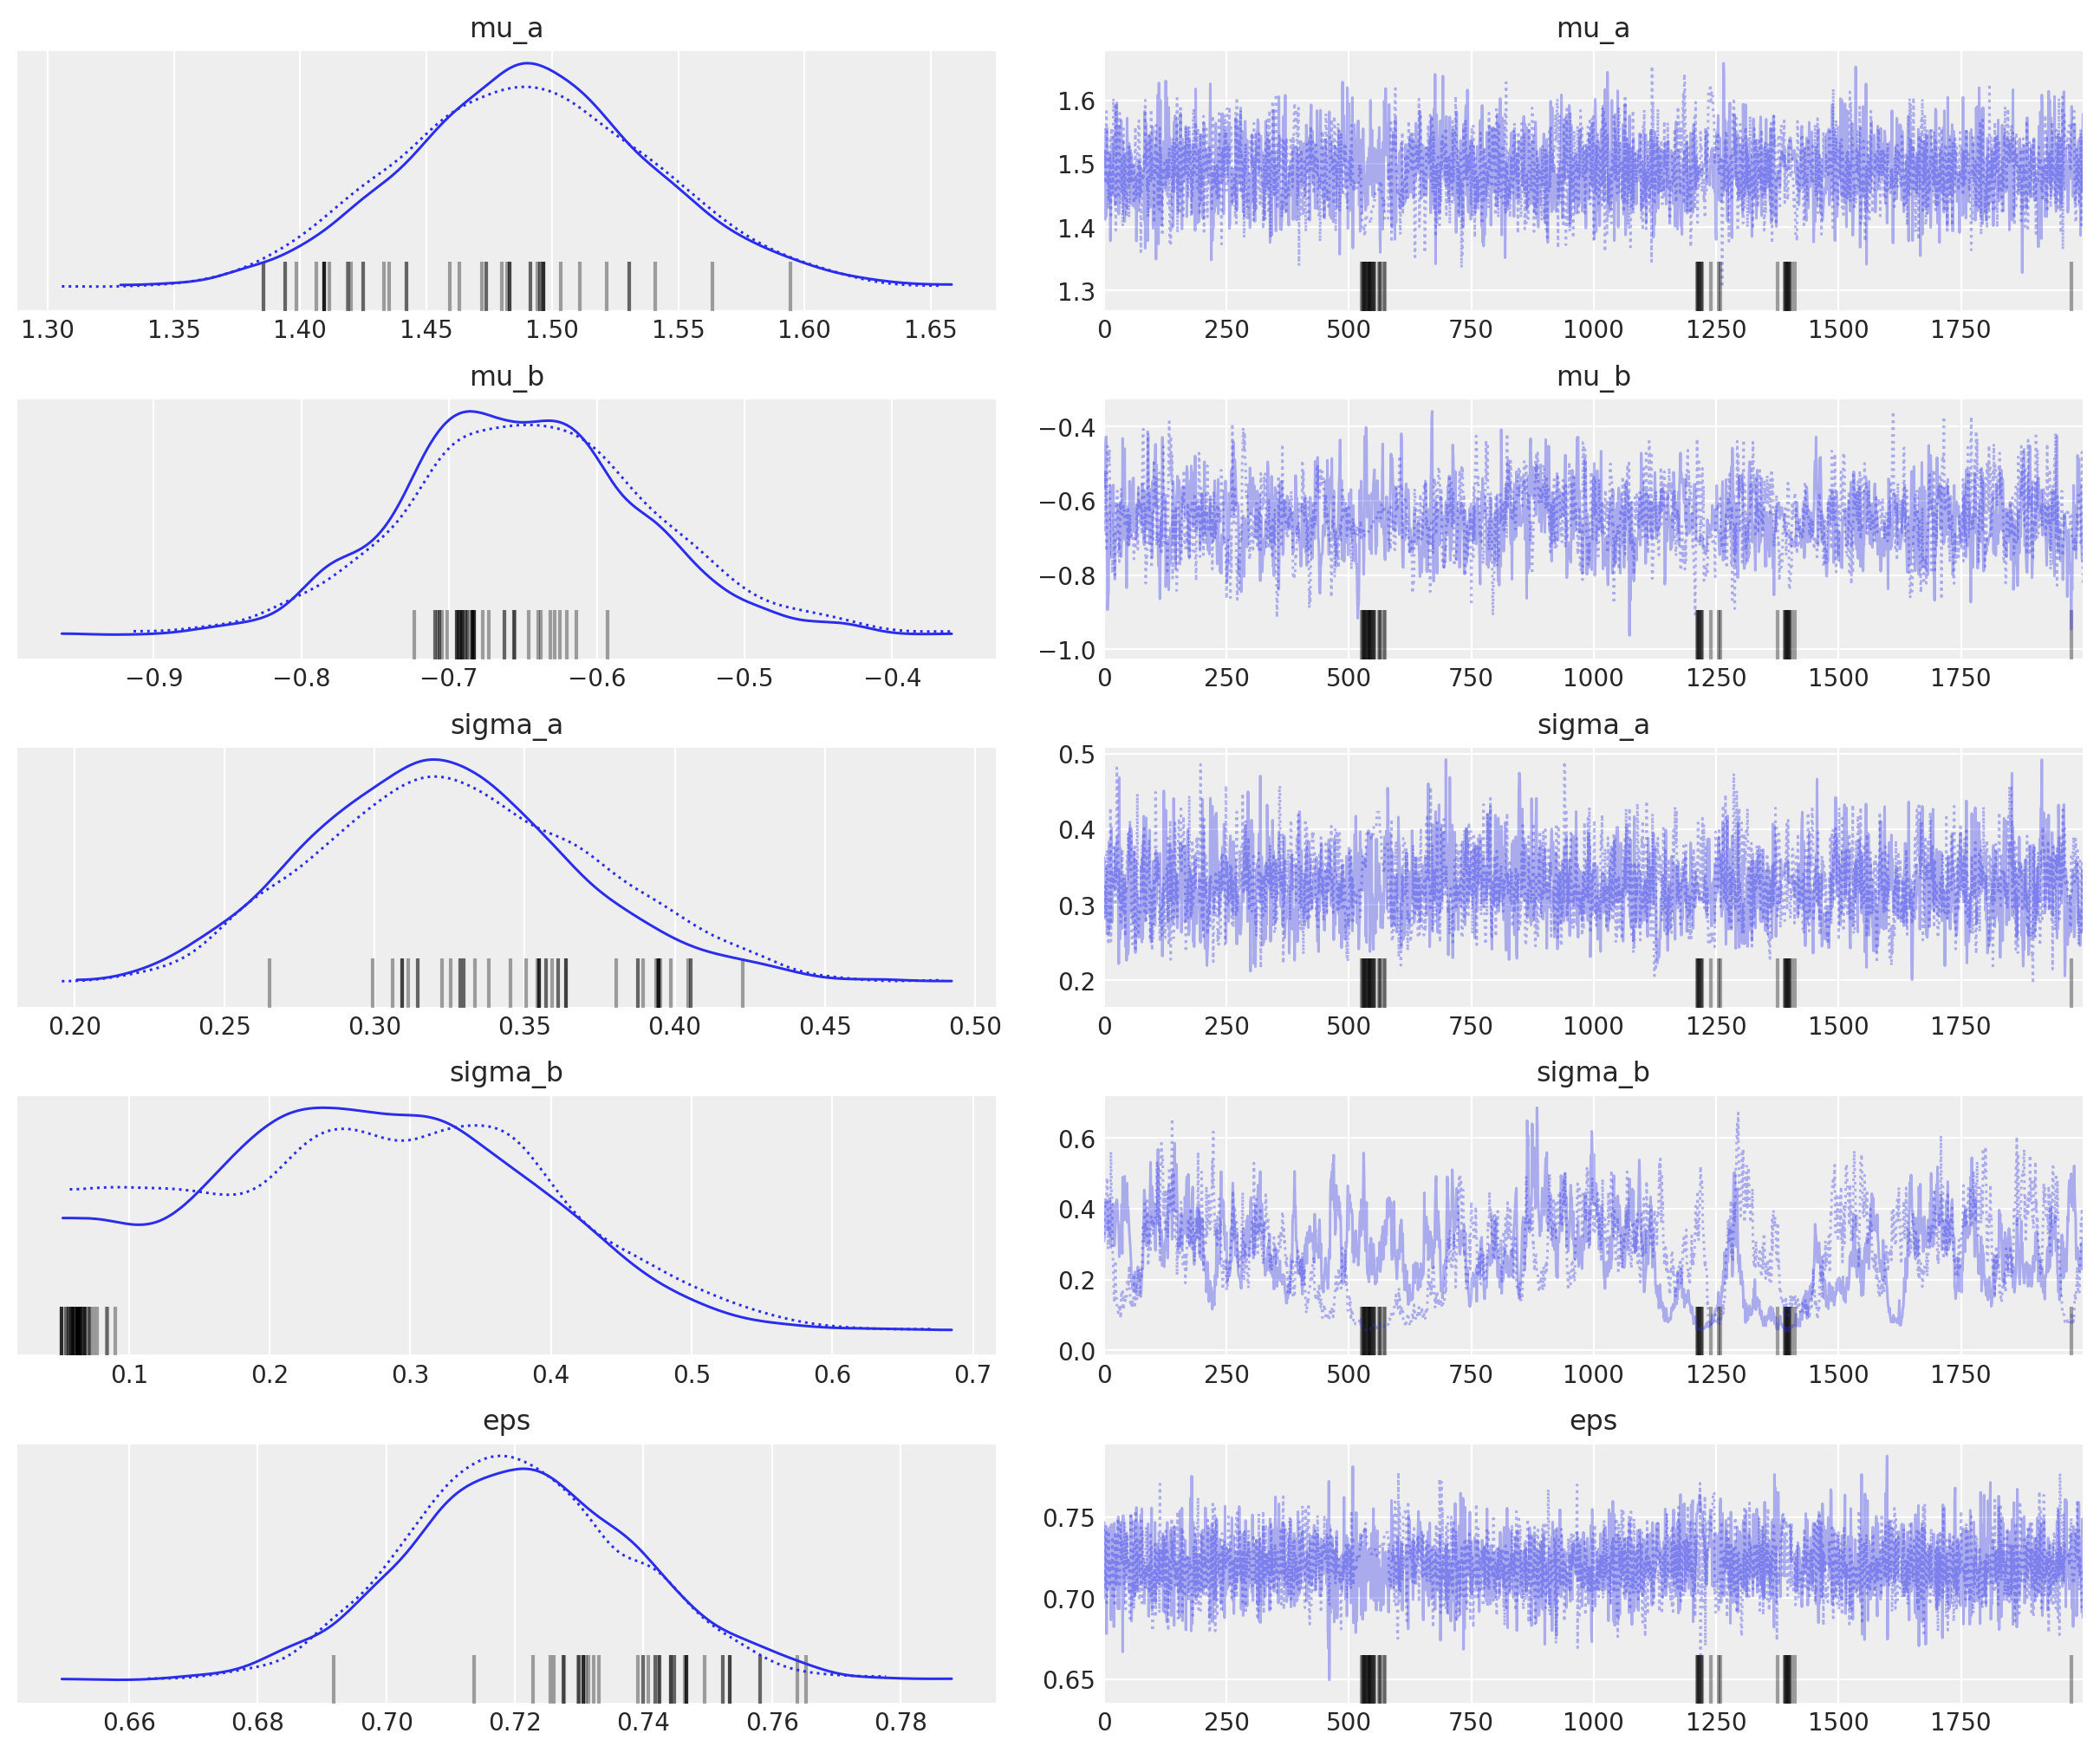

In [14]:
pm.traceplot(hierarchical_trace, 
             var_names=['mu_a', 'mu_b',
                        'sigma_a', 'sigma_b', 
                        'eps'
                       ]
            );

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


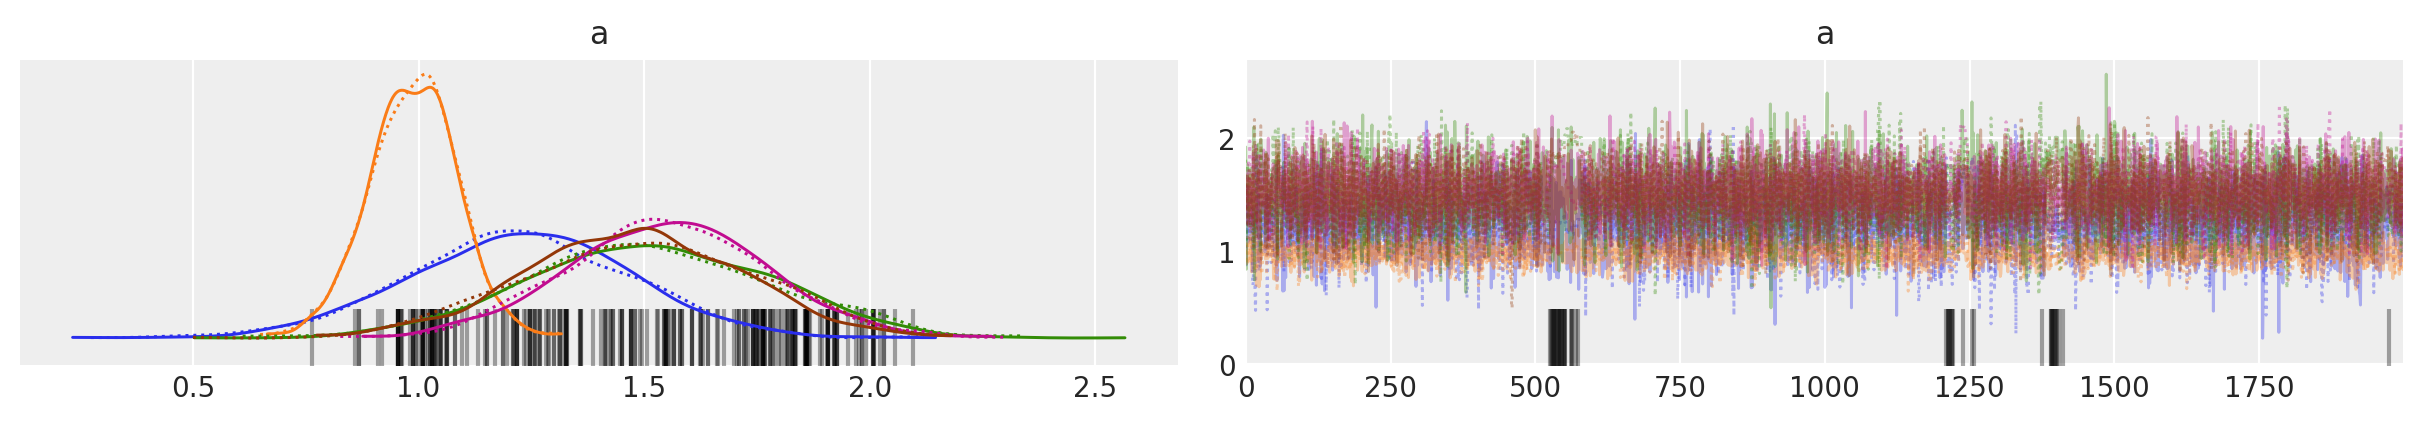

In [15]:
pm.traceplot(hierarchical_trace,
             var_names=['a'], 
             coords={'a_dim_0': range(5)
                    }
            );

## Interpreting Graphs

### 첫번째 4개의 그래프 

mu_a --> tells us the group mean radon levels 

mu_b --> 우리의 모델이 현재 다음과 같다 : radon_est = a[county_idx] + b[county_idx]*data.floor.values 

여기에서 data.floor.values 는 0 또는 1인데, 만약에 0 이면 basement 가 있다는 것이고 1 이면 basement 가 없다고 했다. mu_b 의 값이 대략 -0.7 ~ ~0.5 사이에 분포하므로 basement 가 있을때 (data.floor.values == 0 이면) 보다 basement 가 없을때 (data.floor.values == 1) radon_est 의 값이 낮아지게 된다. 

### 두번째 한개의 그래프 

There is quite some differences in radon levels between counties (each ‘rainbow’ color corresponds to a single county); the different widths are related to how much confidence we have in each parameter estimate – the more measurements per county, the higher our confidence will be.

## Posterior Predictive Check 

우리가 원하는 것은 위 두개의 모델중에 뭐가 더 좋은 모델이냐 이다. 그거를 Root Mean Square Deviaton (RMSD) 를 통하여 알 수 있다. 

/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


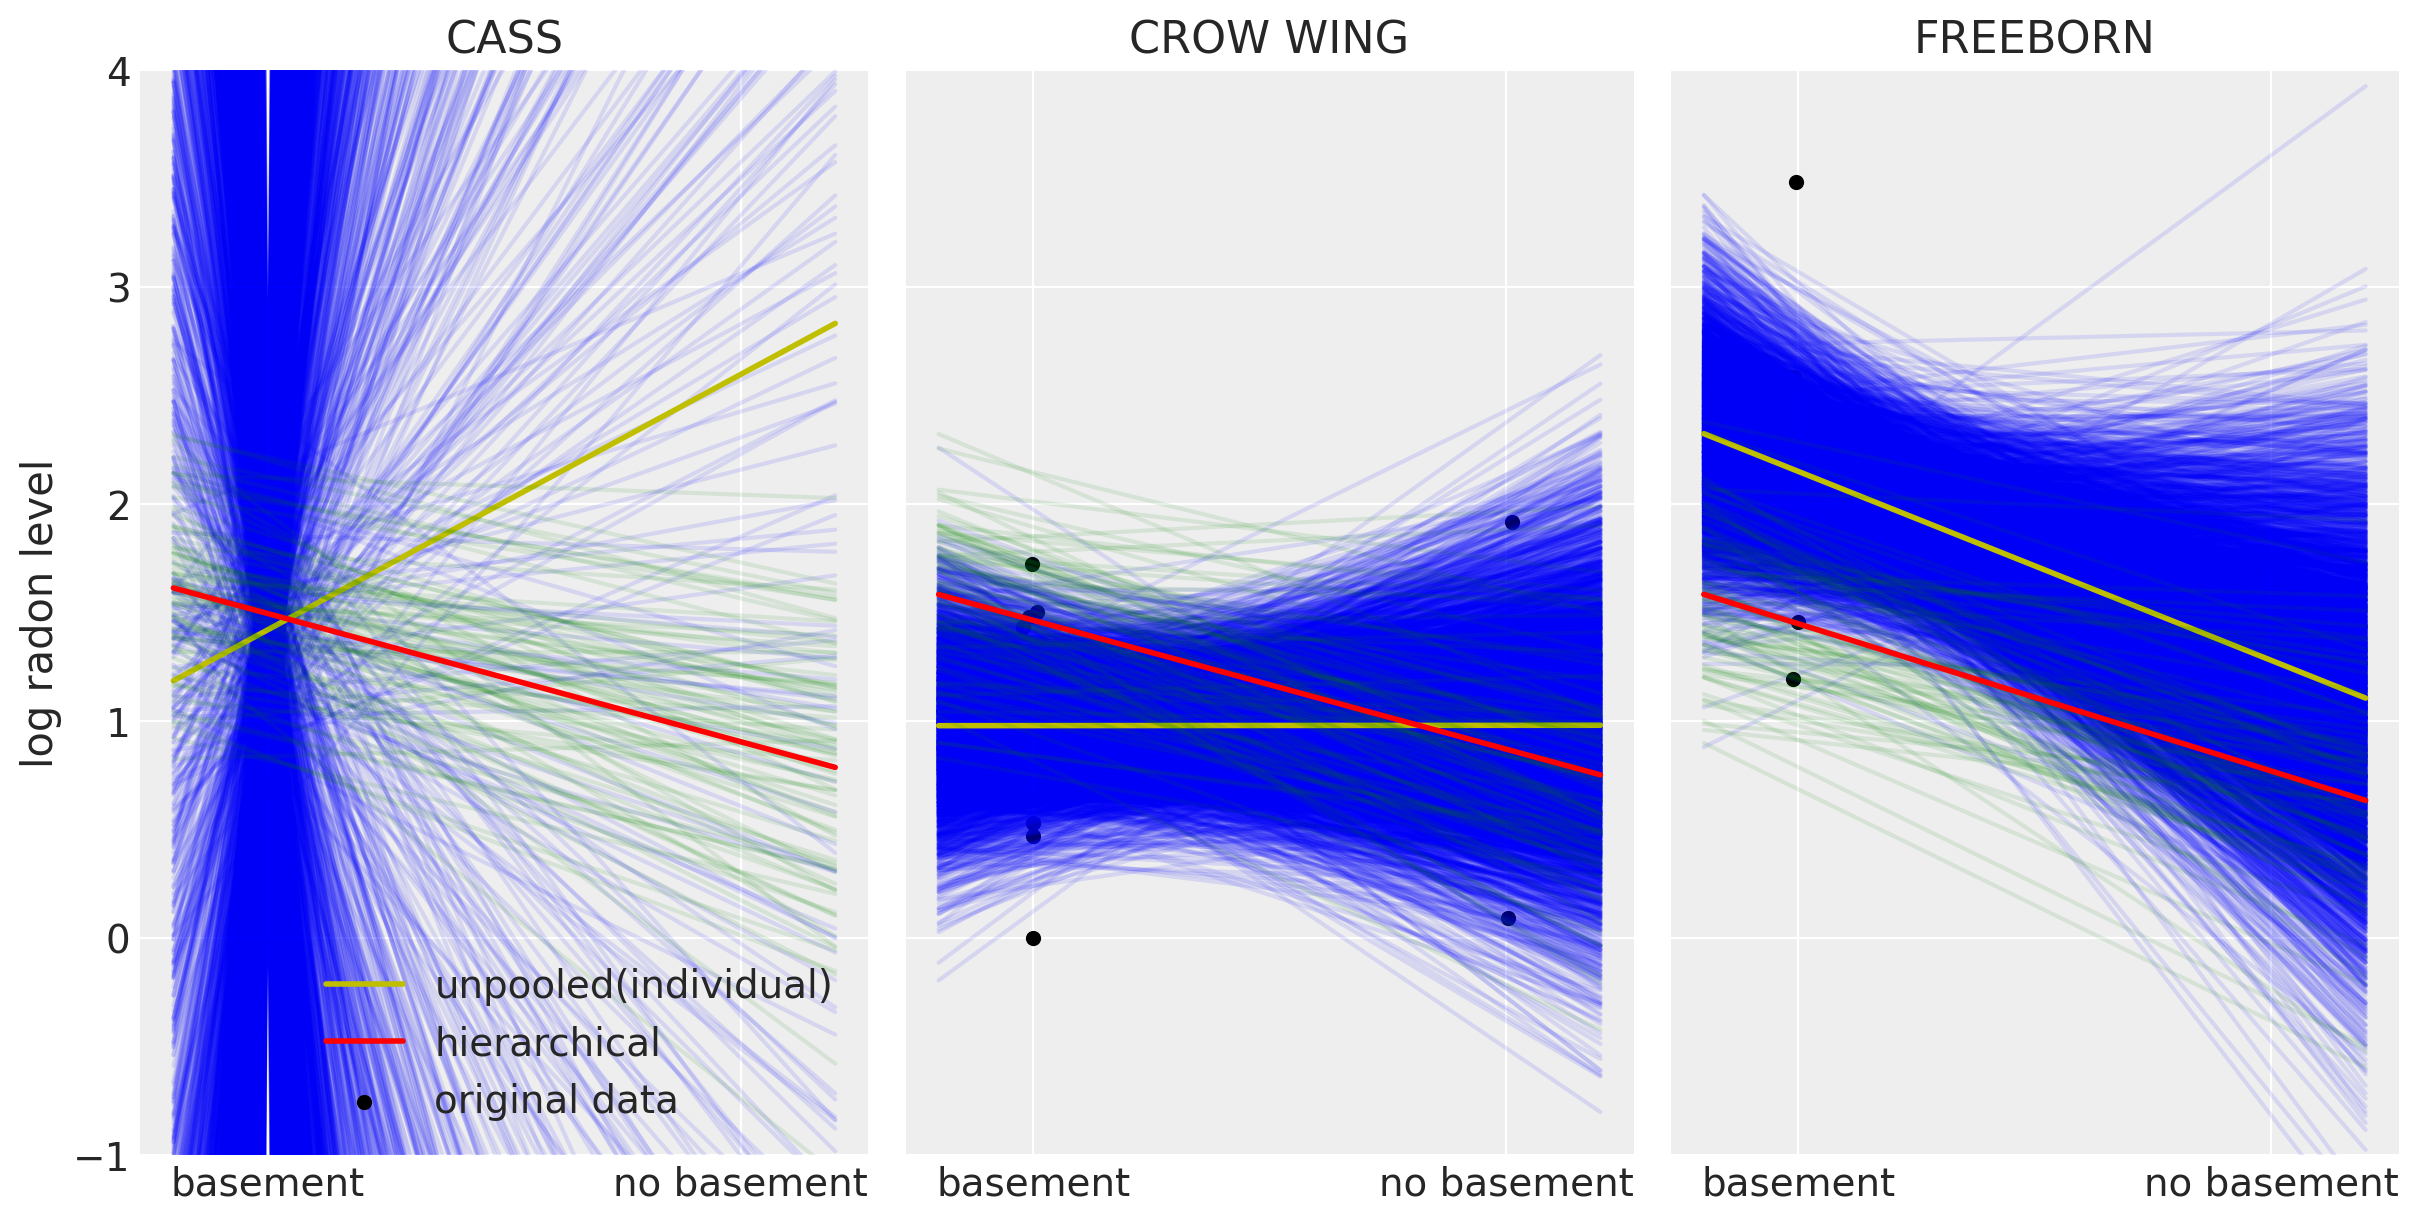

In [16]:
# county 이름들 : 'CASS', 'CROW WING', 'FREEBORN'
selection = ['CASS', 'CROW WING', 'FREEBORN']
fig, axis = plt.subplots(1,3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()

for i, c in enumerate(selection):
    # data.county 가 (예를 들어서) 'CASS' 인 것을 다 가져온다. 그거를 c_data 에 집어 넣어 준다. 
    c_data = data[data.county == c]
    # indexing 을 0 부터 다시 해준다. 
    c_data = c_data.reset_index(drop=True)
    c_index = np.where(county_names == c)[0][0]
    # z 에는 country_code 가 들어감 
    z = list(c_data['county_code'])[0]
    
    xvals = np.linspace(-0.2, 1.2)
    
    for a_val, b_val in zip(unpooled_trace['a'][:, c_index], unpooled_trace['b'][:, c_index]):
        axis[i].plot(xvals, 
                     a_val + b_val * xvals, 
                     'b', 
                     alpha = 0.1)
        
    axis[i].plot(xvals, 
                 unpooled_trace['a'][:, c_index].mean() + unpooled_trace['b'][:, c_index].mean() * xvals, 
                 'y',
                 alpha=1, 
                 lw=2.0,
                 label='unpooled(individual)')
    
    for a_val, b_val in zip(hierarchical_trace['a'][z], hierarchical_trace['b'][z]):
        axis[i].plot(xvals, 
                     a_val + b_val * xvals, 
                     'g', 
                     alpha=0.1)
        
    axis[i].plot(xvals,
                 hierarchical_trace['a'][z].mean() + hierarchical_trace['b'][z].mean() * xvals, 
                 'r',
                 alpha=1,
                 lw=2.0,
                 label='hierarchical'
                )
    
    axis[i].scatter(c_data.floor + np.random.randn(len(c_data)) * 0.01, 
                    c_data.log_radon, 
                    alpha=1,
                    color='k',
                    marker='.',
                    s = 80,
                    label='original data'
                   )
    
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    
    
    axis[0].legend()
    axis[0].set_ylabel('log radon level')
        
    

## Shrinkage

Shrinkage describes the process by which our estimates are “pulled” towards the group-mean as a result of the common group distribution – county-coefficients very far away from the group mean have very low probability under the normality assumption, moving them closer to the group mean gives them higher probability. 

In the non-hierachical model every county is allowed to differ completely from the others by just using each county’s data, resulting in a model more prone to outliers (as shown above).

In [17]:
hier_a = hierarchical_trace['a'][500:].mean(axis=0)
hier_b = hierarchical_trace['b'][500:].mean(axis=0)

indv_a = [unpooled_trace['a'][500:, np.where(county_names==c)[0][0]].mean() for c in county_names]
indv_b = [unpooled_trace['b'][500:, np.where(county_names==c)[0][0]].mean() for c in county_names]

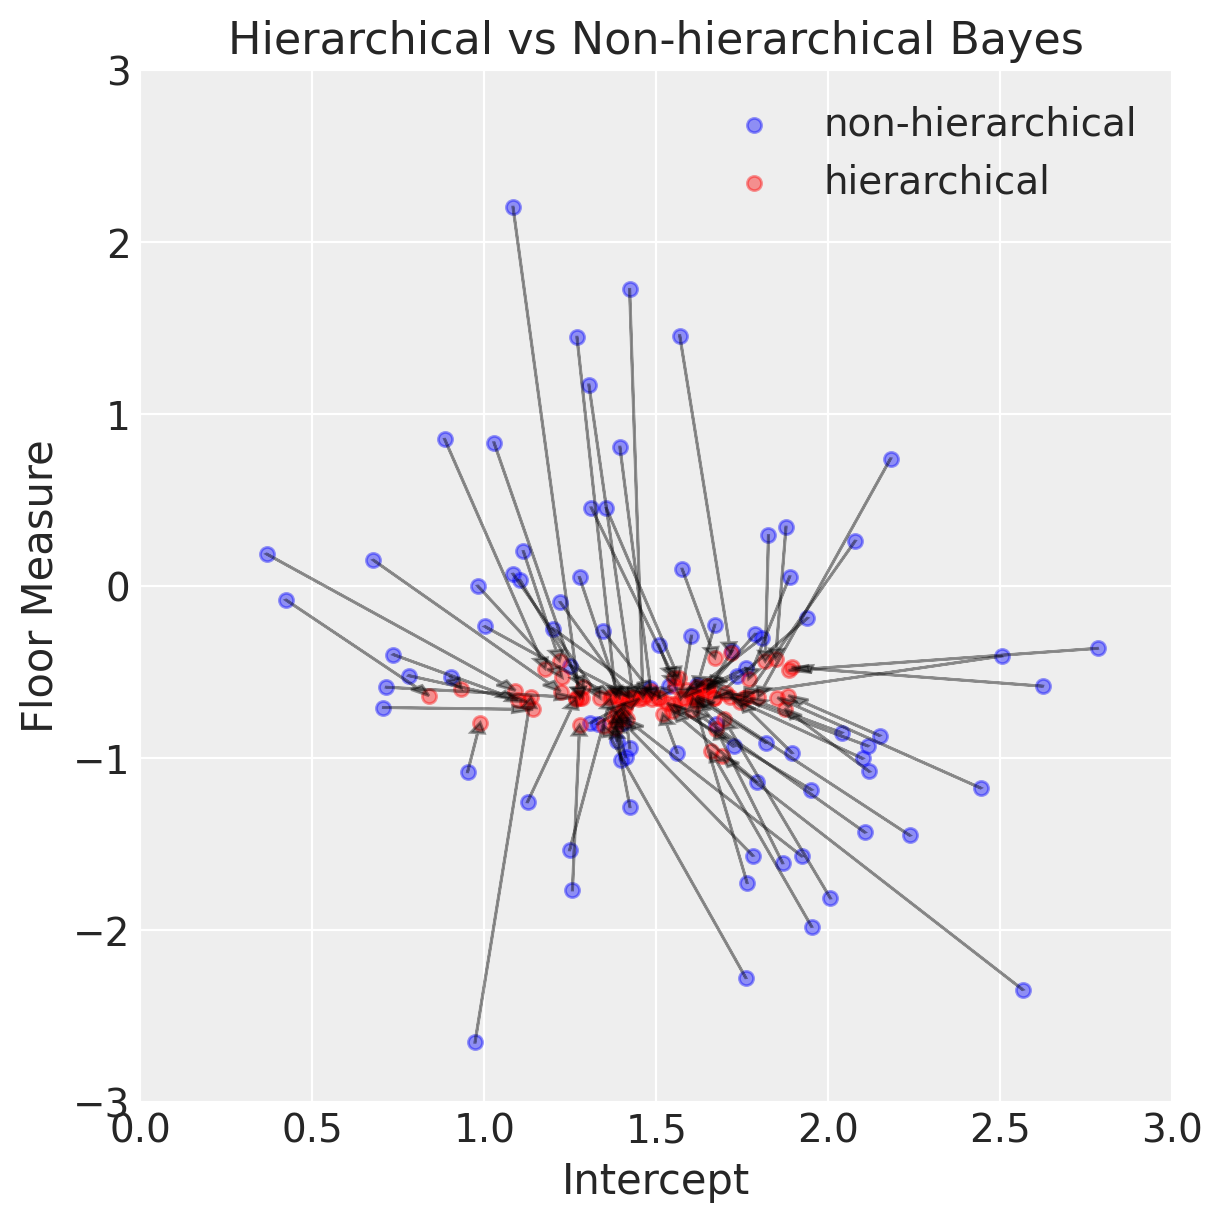

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, 
                     xlabel='Intercept', 
                     ylabel='Floor Measure',
                     title = 'Hierarchical vs Non-hierarchical Bayes',
                     xlim=(0,3),
                     ylim=(-3,3)
                    )

ax.scatter(indv_a, indv_b, c='b', s=26, alpha=0.4, label='non-hierarchical')
ax.scatter(hier_a, hier_b, c='r', s=26, alpha=0.4, label='hierarchical')

for i in range(len(indv_b)):
    ax.arrow(indv_a[i], indv_b[i], 
             hier_a[i] - indv_a[i], hier_b[i] - indv_b[i],
             fc = 'k',
             ec = 'k',
             length_includes_head=True,
             alpha=0.4,
             head_width=0.04
            )
    
ax.legend();